In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [2]:
import torch

# Basic check
print(f"CUDA Available: {torch.cuda.is_available()}")  # Should be True
print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")  # Should show "RTX 4090"

# Advanced check - test tensor operations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.rand(10000, 10000).to(device)  # Move big tensor to GPU
print(f"Tensor device: {x.device}")  # Should print 'cuda:0'

CUDA Available: True
GPU Device Name: NVIDIA GeForce RTX 4090
Tensor device: cuda:0


In [3]:
# Set device for computation (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f'Using device: {device}')

Using device: cuda


In [4]:
import torch
import os
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
from torch.autograd import Variable
from tqdm import tqdm

Processing filename: ATM23_CR12_FR10_PS10_T1.png
Processing filename: ATM23_CR12_FR10_PS10_T2.png
Processing filename: ATM23_CR12_FR10_PS10_T2_1.png
Processing filename: ATM23_CR12_FR10_PS10_T2_10.png
Processing filename: ATM23_CR12_FR10_PS10_T2_11.png
Processing filename: ATM23_CR12_FR10_PS10_T2_12.png
Processing filename: ATM23_CR12_FR10_PS10_T2_13.png
Processing filename: ATM23_CR12_FR10_PS10_T2_14.png
Processing filename: ATM23_CR12_FR10_PS10_T2_15.png
Processing filename: ATM23_CR12_FR10_PS10_T2_16.png
Processing filename: ATM23_CR12_FR10_PS10_T2_17.png
Processing filename: ATM23_CR12_FR10_PS10_T2_18.png
Processing filename: ATM23_CR12_FR10_PS10_T2_19.png
Processing filename: ATM23_CR12_FR10_PS10_T2_2.png
Processing filename: ATM23_CR12_FR10_PS10_T2_20.png
Processing filename: ATM23_CR12_FR10_PS10_T2_21.png
Processing filename: ATM23_CR12_FR10_PS10_T2_22.png
Processing filename: ATM23_CR12_FR10_PS10_T2_23.png
Processing filename: ATM23_CR12_FR10_PS10_T2_24.png
Processing filename:

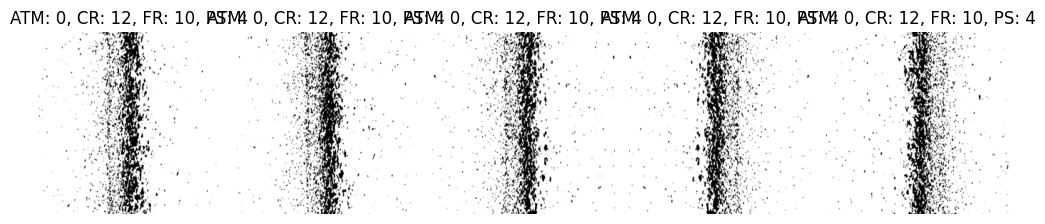

Total images loaded: 23367
Number of batches: 366


In [5]:
# Load the preprocessed data from the .pth file
image_folder = r'C:\Users\Das-Lab-Admin\Downloads\Shihab_deep learning_GAN\Model data\All images after augmentation_23k'
def parse_filename(filename):
    match = re.match(r"ATM(\d+)_CR(\d+)_FR(\d+)_PS(\d+)_T\d+(?:_\d+)?\.png", filename)
    
    if match:
        ATM_value = int(match.group(1))
        ATM_mapping = {23: 0, 30: 1, 36: 2}
        ATM_value = ATM_mapping.get(ATM_value, -1)

        CR_value = int(match.group(2))
        FR_value = int(match.group(3))
        PS_value = int(match.group(4))
        PS_value = (PS_value - 2) // 2

        if PS_value < 0 or PS_value > 4:
            return None, None, None, None


        return ATM_value, CR_value, FR_value, PS_value
    return None, None, None, None


# Load all images and preprocess
image_data = []
for filename in os.listdir(image_folder):
    if filename.endswith('.png'):
        print(f"Processing filename: {filename}")  # Debugging step
        ATM_value, CR_value, FR_value, PS_value = parse_filename(filename)
        if ATM_value is not None and CR_value is not None and FR_value is not None and PS_value is not None:
            # print("Condition satisfied")
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image = image.resize((256, 256))  # Resize to 512 x 512
            image_np = np.array(image)
            image_data.append((image_np, ATM_value, CR_value, FR_value, PS_value))

sample_images = image_data[:5]  # Take the first 5 images for display

# Display sample images with labels
plt.figure(figsize=(10, 5))
for i, (img_np, ATM_value, CR_value, FR_value, PS_value) in enumerate(sample_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_np, cmap='gray')
    plt.title(f'ATM: {ATM_value}, CR: {CR_value}, FR: {FR_value}, PS: {PS_value}')
    plt.axis('off')  # Turn off axis labels
plt.tight_layout()
plt.show()

# Convert data to tensors and create batches
batch_size = 64
batches = []
for i in range(0, len(image_data), batch_size):
    batch = image_data[i:i + batch_size]
    
    # Process images one by one to avoid memory buildup
    img_tensors = []
    ATM_values = []
    CR_values = []
    FR_values = []
    PS_values = []
    
    for img_np, ATM_value, CR_value, FR_value, PS_value in batch:
        # Process and normalize on CPU first
        img_tensor = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        img_tensor = (img_tensor / 255.0) * 2 - 1  # Normalize to [-1, 1]
        
        img_tensors.append(img_tensor)
        ATM_values.append(ATM_value)
        CR_values.append((CR_value - 6) // 3)
        FR_values.append(FR_value - 1)
        PS_values.append(PS_value)
    
    # Concatenate on CPU first
    batch_images = torch.cat(img_tensors, dim=0)
    # Then move to GPU
    batch_images = batch_images.unsqueeze(1).to(device)  # Add channel dim and move to GPU
    
    batches.append((
        batch_images,
        torch.tensor(ATM_values).to(device),
        torch.tensor(CR_values).to(device),
        torch.tensor(FR_values).to(device),
        torch.tensor(PS_values).to(device)
    ))
    

print(f"Total images loaded: {len(image_data)}")
print(f"Number of batches: {len(batches)}")

In [6]:
#batch_size = 64
print(f"Total images loaded: {len(image_data)}")
print(f"Batch tensor shape: {batch_images.shape}")

Total images loaded: 23367
Batch tensor shape: torch.Size([7, 1, 256, 256])


In [7]:
# Hyperparameters
latent_dim = 100  # Latent space dimension (noise vector)
img_size = 256    # Image size (512x512)
channels = 1      # Binary images (grayscale)
num_classes_ATM = 3  # Number of ATM classes (ATM is catagorical with values 23, 30, 36)
num_classes_CR = 3   # Number of CR classes (CR is catagorical with values 6, 9, 12, but neumerical is possible)
num_classes_FR = 15  # Number of FR classes (FR ranges from 1 to 15)
num_classes_PS = 5   # Number of PS classes (PS ranges from 2 to 10, with 2 increment)
epochs = 100
sample_interval = 1

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes_ATM, num_classes_CR, num_classes_FR, num_classes_PS, img_size=256):
        super(Generator, self).__init__()
        self.label_emb_ATM = nn.Embedding(num_classes_ATM, num_classes_ATM)
        self.label_emb_CR = nn.Embedding(num_classes_CR, num_classes_CR)
        self.label_emb_FR = nn.Embedding(num_classes_FR, num_classes_FR)
        self.label_emb_PS = nn.Embedding(num_classes_PS, num_classes_PS)

        self.init_size = img_size // 4  # 256 → 64that
        self.l1 = nn.Sequential(nn.Linear(
            latent_dim + num_classes_ATM + num_classes_CR + num_classes_FR + num_classes_PS,
            128 * self.init_size ** 2
        ))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),                        # 64 → 128
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),                        # 128 → 256
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels_ATM, labels_CR, labels_FR, labels_PS):
        label_ATM = self.label_emb_ATM(labels_ATM)
        label_CR = self.label_emb_CR(labels_CR)
        label_FR = self.label_emb_FR(labels_FR)
        label_PS = self.label_emb_PS(labels_PS)

        # Concatenate noise + embedded labels
        x = torch.cat((noise, label_ATM, label_CR, label_FR, label_PS), dim=-1)
        out = self.l1(x)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [3]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_size=256, num_classes_ATM=3, num_classes_CR=3, num_classes_FR=15, num_classes_PS=5):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1 + 4, 16, kernel_size=3, stride=2, padding=1),   # 256 → 128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),      # 128 → 64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),      # 64 → 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),     # 32 → 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),    # 16 → 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),    # 8 → 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )

        # Label embeddings for conditional inputs
        self.label_embedding_ATM = nn.Embedding(num_classes_ATM, img_size * img_size)
        self.label_embedding_CR = nn.Embedding(num_classes_CR, img_size * img_size)
        self.label_embedding_FR = nn.Embedding(num_classes_FR, img_size * img_size)
        self.label_embedding_PS = nn.Embedding(num_classes_PS, img_size * img_size)

    def forward(self, img, labels_ATM, labels_CR, labels_FR, labels_PS):
        # Embed and reshape labels to match image spatial dimensions
        label_ATM_flat = self.label_embedding_ATM(labels_ATM).view(labels_ATM.size(0), 1, img.size(2), img.size(3))
        label_CR_flat = self.label_embedding_CR(labels_CR).view(labels_CR.size(0), 1, img.size(2), img.size(3))
        label_FR_flat = self.label_embedding_FR(labels_FR).view(labels_FR.size(0), 1, img.size(2), img.size(3))
        label_PS_flat = self.label_embedding_PS(labels_PS).view(labels_PS.size(0), 1, img.size(2), img.size(3))

        # Concatenate image and condition maps
        d_in = torch.cat((img, label_ATM_flat, label_CR_flat, label_FR_flat, label_PS_flat), dim=1)
        validity = self.model(d_in)
        return validity


In [5]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

TypeError: Generator.__init__() missing 5 required positional arguments: 'latent_dim', 'num_classes_ATM', 'num_classes_CR', 'num_classes_FR', and 'num_classes_PS'

In [38]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss().to(device)

In [39]:
# Lists to store loss values
g_losses = []
d_losses = []

def generate_sample_images(epoch, generator, latent_dim, num_classes_ATM, num_classes_CR, num_classes_FR, num_classes_PS):
    r, c = 1, 5  # 1 row and 5 columns for visualization
    noise = torch.randn(r * c, latent_dim).to(device)
    
    # Sample labels
    sampled_labels_ATM = torch.randint(0, num_classes_ATM, (r * c,)).to(device)
    sampled_labels_CR = torch.randint(0, num_classes_CR, (r * c,)).to(device)
    sampled_labels_FR = torch.randint(0, num_classes_FR, (r * c,)).to(device)
    sampled_labels_PS = torch.randint(0, num_classes_PS, (r * c,)).to(device)

    # Generate images
    with torch.no_grad():
        gen_imgs = generator(noise, sampled_labels_ATM, sampled_labels_CR, sampled_labels_FR, sampled_labels_PS)
    
    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Plot
    fig, axs = plt.subplots(r, c, figsize=(15, 3))
    for i in range(c):
        axs[i].imshow(gen_imgs[i, 0].cpu().detach().numpy(), cmap='gray')
        axs[i].set_title(
            f"ATM: {sampled_labels_ATM[i].item()}, CR: {sampled_labels_CR[i].item()}, "
            f"FR: {sampled_labels_FR[i].item()}, PS: {sampled_labels_PS[i].item()}",
            fontsize=7
        )
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Training loop
for epoch in range(epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    num_batches = 0
    
    for i, (real_imgs, ATM_values, CR_values, FR_values, PS_values) in enumerate(tqdm(batches, desc=f"Epoch {epoch+1}")):
        batch_size = real_imgs.size(0)
        
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        real_loss = adversarial_loss(discriminator(real_imgs, ATM_values, CR_values, FR_values, PS_values), valid)
        
        # Fake images
        noise = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(noise, ATM_values, CR_values, FR_values, PS_values)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), ATM_values, CR_values, FR_values, PS_values), fake)
        
        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate images again (discriminator has been updated)
        gen_imgs = generator(noise, ATM_values, CR_values, FR_values, PS_values)
        
        # Generator loss
        g_loss = adversarial_loss(discriminator(gen_imgs, ATM_values, CR_values, FR_values, PS_values), valid)
        g_loss.backward()
        optimizer_G.step()

        # Accumulate losses
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        num_batches += 1

    # Calculate average epoch losses
    epoch_d_loss /= num_batches
    epoch_g_loss /= num_batches
    epoch_joint_loss = epoch_d_loss + epoch_g_loss
    
    # Store losses
    loss_history['epoch'].append(epoch+1)
    loss_history['d_loss'].append(epoch_d_loss)
    loss_history['g_loss'].append(epoch_g_loss)
    loss_history['joint_loss'].append(epoch_joint_loss)

    # Print progress
    print(f"[Epoch {epoch+1}/{epochs}] D loss: {epoch_d_loss:.4f}, G loss: {epoch_g_loss:.4f}, Joint: {epoch_joint_loss:.4f}")

    # Save generated images EVERY epoch
    with torch.no_grad():
        # Generate images with fixed noise for consistency
        fixed_noise = torch.randn(64, latent_dim).to(device)
        sample_ATM = torch.randint(0, num_classes_ATM, (64,)).to(device)
        sample_CR = torch.randint(0, num_classes_CR, (64,)).to(device)
        sample_FR = torch.randint(0, num_classes_FR, (64,)).to(device)
        sample_PS = torch.randint(0, num_classes_PS, (64,)).to(device)
        
        gen_imgs = generator(fixed_noise, sample_ATM, sample_CR, sample_FR, sample_PS)
    
    # Save grid image
    save_image(gen_imgs.data, 
              f"training_results/grid_images/epoch_{epoch+1:03d}.png", 
              nrow=8, 
              normalize=True)
    
    # Save individual images
    epoch_dir = f"training_results/individual_images/epoch_{epoch+1:03d}"
    os.makedirs(epoch_dir, exist_ok=True)
    for i, img in enumerate(gen_imgs):
        save_image(img, f"{epoch_dir}/sample_{i:03d}.png", normalize=True)

# Create and save loss plot with all three curves
plt.figure(figsize=(12, 6))
plt.plot(loss_history['epoch'], loss_history['d_loss'], label="Discriminator Loss", alpha=0.8, linestyle='--')
plt.plot(loss_history['epoch'], loss_history['g_loss'], label="Generator Loss", alpha=0.8, linestyle='--')
plt.plot(loss_history['epoch'], loss_history['joint_loss'], label="Joint Loss", linewidth=2, color='red')
plt.title("Training Losses Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_results/loss_plots/training_losses.png", dpi=300, bbox_inches='tight')
plt.close()

# Save loss data to Excel
loss_df = pd.DataFrame(loss_history)
loss_df.to_excel("training_results/loss_history.xlsx", index=False)

print("Training complete! All results saved to training_results/ directory")
print(f"Final losses - D: {loss_history['d_loss'][-1]:.4f}, G: {loss_history['g_loss'][-1]:.4f}, Joint: {loss_history['joint_loss'][-1]:.4f}")

Epoch 1:   0%|          | 1/366 [04:03<24:42:34, 243.71s/it]

In [20]:
# At the end of your training loop, modify the plotting code:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Save the figure instead of/in addition to showing it
loss_plot_path = "training_losses.png"  # or use f"losses_epoch{epochs}.png"
plt.savefig(loss_plot_path)
plt.close()  # Close the figure to free memory

In [24]:
import os

# Create directories if they don't exist
os.makedirs("images", exist_ok=True)
os.makedirs("samples", exist_ok=True)
os.makedirs("logs", exist_ok=True)

In [28]:
import os
from torchvision.utils import save_image

# Create directories (do this once before your training loop)
os.makedirs("training_samples", exist_ok=True)  # Main directory
os.makedirs("training_samples/grids", exist_ok=True)  # For grid images
os.makedirs("training_samples/individual", exist_ok=True)  # For individual images

# Inside your training loop (modify your existing sampling code):
if True:  # Remove condition to save every epoch, or keep your sample_interval
    with torch.no_grad():
        # Create fixed noise for consistent samples
        fixed_noise = torch.randn(64, latent_dim).to(device)
        
        # Create sample conditions (modify as needed)
        sample_ATM = torch.randint(0, num_classes_ATM, (64,)).to(device)
        sample_CR = torch.randint(0, num_classes_CR, (64,)).to(device)
        sample_FR = torch.randint(0, num_classes_FR, (64,)).to(device)
        sample_PS = torch.randint(0, num_classes_PS, (64,)).to(device)
        
        gen_imgs = generator(fixed_noise, sample_ATM, sample_CR, sample_FR, sample_PS)
    
    # Save grid image (8x8 by default)
    save_image(gen_imgs.data, 
              f"training_samples/grids/epoch_{epoch+1:04d}.png", 
              nrow=8, 
              normalize=True)
    
    # Save individual images
    epoch_dir = f"training_samples/individual/epoch_{epoch+1:04d}"
    os.makedirs(epoch_dir, exist_ok=True)
    
    for i, img in enumerate(gen_imgs):
        save_image(img, 
                 f"{epoch_dir}/sample_{i:04d}.png", 
                 normalize=True)

In [22]:
# At the end of your training loop, save the losses to a file
import csv

# Save loss logs
with open('training_logs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Epoch', 'Generator Loss', 'Discriminator Loss'])
    for epoch in range(epochs):
        writer.writerow([epoch+1, g_losses[epoch], d_losses[epoch]])

In [27]:
from torchvision.utils import save_image  # Add this import at the top of your script

if (epoch + 1) % sample_interval == 0:
    # Generate and save sample images
    with torch.no_grad():
        # Create a fixed noise for consistent samples across epochs
        fixed_noise = torch.randn(64, latent_dim).to(device)
        # Create some sample conditional values (adjust as needed)
        sample_ATM = torch.randint(0, num_classes_ATM, (64,)).to(device)
        sample_CR = torch.randint(0, num_classes_CR, (64,)).to(device)
        sample_FR = torch.randint(0, num_classes_FR, (64,)).to(device)
        sample_PS = torch.randint(0, num_classes_PS, (64,)).to(device)
        
        gen_imgs = generator(fixed_noise, sample_ATM, sample_CR, sample_FR, sample_PS)
    
    # Make grid and save
    save_image(gen_imgs.data, f"images/epoch_{epoch+1}.png", nrow=8, normalize=True)
    
    # If you want to keep individual samples
    os.makedirs(f"samples/epoch_{epoch+1}", exist_ok=True)
    for i, img in enumerate(gen_imgs):
        save_image(img, f"samples/epoch_{epoch+1}/sample_{i}.png", normalize=True)

In [18]:
# Function to generate labels for ATM, CR, FR and V
def generate_labels(batch_size, num_classes_ATM, num_classes_CR, num_classes_FR, num_classes_PS, device):
    labels_ATM = torch.randint(0, num_classes_ATM, (batch_size,), device=device)
    labels_CR = torch.randint(0, num_classes_CR, (batch_size,), device=device)
    labels_FR = torch.randint(0, num_classes_FR, (batch_size,), device=device)
    labels_PS = torch.randint(0, num_classes_PS, (batch_size,), device=device)
    return labels_ATM, labels_CR, labels_FR, labels_PS
    #if above line shows error, you can use the below
    #return torch.LongTensor(labels_ATM).to(device), torch.LongTensor(labels_CR).to(device), torch.LongTensor(labels_FR).to(device), torch.LongTensor(labels_PS).to(device)

In [19]:
# Save the generator and discriminator
torch.save(generator.state_dict(), 'generator_256.pth')
torch.save(discriminator.state_dict(), 'discriminator_256.pth')
# Optionally, save the optimizer states if you want to continue training
torch.save(optimizer_G.state_dict(), 'optimizer_G_256.pth')
torch.save(optimizer_D.state_dict(), 'optimizer_D_256.pth')

Loading the Model

When you want to load the saved models for future use (e.g., for generating images or continuing training):

In [ ]:
# Initialize the models (they should be created with the same architecture)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Load the saved state dictionaries
generator.load_state_dict(torch.load('generator.pth'))
discriminator.load_state_dict(torch.load('discriminator.pth'))

# If you want to continue training, also load the optimizers
optimizer_G.load_state_dict(torch.load('optimizer_G.pth'))
optimizer_D.load_state_dict(torch.load('optimizer_D.pth'))

In [ ]:
# Initialize the models (they should be created with the same architecture)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Load the saved state dictionaries
generator.load_state_dict(torch.load('generator.pth'))
discriminator.load_state_dict(torch.load('discriminator.pth'))

# If you want to continue training, also load the optimizers
optimizer_G.load_state_dict(torch.load('optimizer_G.pth'))
optimizer_D.load_state_dict(torch.load('optimizer_D.pth'))

In [27]:
def generate_specific_image(ATM_value, CR_value, FR_value, PS_value, generator, latent_dim, device):
   
    # Generate random noise
    noise = torch.randn(1, latent_dim, device=device)
# Create labels as tensors
    ATM_label = torch.tensor([ATM_value], dtype=torch.long, device=device)
    CR_label = torch.tensor([CR_value], dtype=torch.long, device=device)
    FR_label = torch.tensor([FR_value], dtype=torch.long, device=device)
    PS_label = torch.tensor([PS_value], dtype=torch.long, device=device)

    # Generate the image using the generator
    with torch.no_grad():
        gen_img = generator(noise, ATM_label, CR_label, FR_label, PS_label).cpu()
    
    # Rescale image from [-1, 1] to [0, 1]
    gen_img = 0.5 * gen_img + 0.5

    # Return the generated image as a numpy array
    return gen_img[0, 0].numpy()

    # Return the image
    return gen_img[0, 0].numpy()

# Example: Generate an image with specific labels
ATM_value = 2
CR_value = 1
FR_value = 3
PS_value = 1
latent_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function
generated_image = generate_specific_image(ATM_value, CR_value, FR_value, PS_value, generator, latent_dim, device)

# Visualize the image (optional)
import matplotlib.pyplot as plt
plt.imshow(generated_image, cmap='gray')
plt.title(f"ATM={ATM_value}, CR={CR_value}, FR={FR_value}, PS={PS_value}")
plt.axis('off')
plt.show()

array([[4.2184293e-03, 2.1678209e-04, 4.9170852e-04, ..., 1.1920929e-07,
        2.9802322e-08, 2.5957823e-05],
       [5.4657459e-05, 1.4901161e-07, 2.5033951e-06, ..., 1.2516975e-06,
        0.0000000e+00, 1.2367964e-05],
       [4.7355890e-05, 2.0861626e-07, 4.8577785e-06, ..., 7.5641870e-03,
        5.0663948e-07, 1.8352270e-04],
       ...,
       [6.6488981e-05, 0.0000000e+00, 8.8363886e-05, ..., 8.3744526e-06,
        0.0000000e+00, 8.9406967e-07],
       [5.2779913e-05, 0.0000000e+00, 5.1856041e-06, ..., 0.0000000e+00,
        0.0000000e+00, 2.9802322e-08],
       [2.0384789e-05, 0.0000000e+00, 2.9802322e-08, ..., 0.0000000e+00,
        0.0000000e+00, 1.1920929e-07]], dtype=float32)

In [19]:
print("Image 1 range:", np.min(image_11), np.max(image_11))

NameError: name 'image_11' is not defined